# Final Project: Kickstarter Dataset
## Corbin Higgs, Zach Meyer, Jacob Ulman
##                              What makes a Kickstarter campaign succeed?

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score,  classification_report, confusion_matrix, r2_score

%matplotlib inline

In [25]:
df = pd.read_csv("data/kickstarter.csv")
#df.head(2)

In [26]:
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])

df['timediffdays'] = (df['deadline'] - df['launched']).dt.days

df.head(2)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,timediffdays
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59


In [27]:
le = LabelEncoder()
df['maincat'] = le.fit_transform(df['main_category'])
df['state_encoded'] = le.fit_transform(df['state'])

df.head(2)

#Clearing out unkown, suspended, and live projects as they are not failed or successful
df = df.loc[(df['state_encoded'] != 5)]
df = df.loc[(df['state_encoded'] != 4)]
df = df.loc[(df['state_encoded'] != 2)]

#Re-encoding the states
df['state_encoded'] = le.fit_transform(df['state'])

#fixing encoding
state = []
for item, frame in df['state'].iteritems():
        if (frame == 'successful'):
            state += [1]
        else:
            state += [0]

df['state_encoded'] = state

In [28]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,timediffdays,maincat,state_encoded
ID,1,0.0017,0.00057,0.00064,-0.00047,6.7e-05,0.0019,-7.9e-05,-0.00096,-0.00089
goal,0.0017,1,0.0075,0.0042,0.0058,0.0053,0.94,0.0047,0.0037,-0.025
pledged,0.00057,0.0075,1,0.72,0.86,0.95,0.0053,0.00097,0.005,0.11
backers,0.00064,0.0042,0.72,1,0.7,0.75,0.0047,-0.00082,0.00045,0.13
usd pledged,-0.00047,0.0058,0.86,0.7,1,0.91,0.0065,0.00096,0.0058,0.098
usd_pledged_real,6.7e-05,0.0053,0.95,0.75,0.91,1,0.0058,0.0011,0.0062,0.11
usd_goal_real,0.0019,0.94,0.0053,0.0047,0.0065,0.0058,1,0.0046,0.002,-0.024
timediffdays,-7.9e-05,0.0047,0.00097,-0.00082,0.00096,0.0011,0.0046,1,0.0069,-0.028
maincat,-0.00096,0.0037,0.005,0.00045,0.0058,0.0062,0.002,0.0069,1,-0.032
state_encoded,-0.00089,-0.025,0.11,0.13,0.098,0.11,-0.024,-0.028,-0.032,1


In [29]:
feature_names_1 = ['usd_goal_real','timediffdays','maincat','backers']
features_1 = df[feature_names_1]
labels = df['state_encoded']

#data splitting
x_train, x_test, y_train, y_test = train_test_split(features_1, labels, test_size=0.33, random_state=42)

In [30]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(n_estimators=10)
scoring = 'accuracy'
# estimates accuracy
scores = cross_validate(model, x_train, y_train, scoring=[scoring] , cv=10)
best_score = np.max(scores['test_' + scoring])
print('Random Tree Best Classifier')
print('best {0} score : {1}'.format(scoring, best_score))
# create predictions 
y_pred = cross_val_predict(model, x_train, y_train, cv = 10)
print('true', confusion_matrix(y_train, y_pred), '\n predicted')

# Number of trees in random forest
n_estimators  = np.arange(10,30, 10)
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [3,4,5]
# Minimum number of samples required to split a node
min_samples_split = np.arange(2, 6, 2)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2, 6, 2)
# Method of selecting samples for training each tree
param_grid= {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(param_grid)

model = RandomForestClassifier(n_estimators=10)
model = GridSearchCV(model, param_grid = param_grid,cv = 5,scoring=scoring, n_jobs = -1,  refit=True)

model = model.fit(x_train, y_train)


Random Tree Best Classifier
best accuracy score : 0.9250231658676121
true [[149130   9358]
 [ 10304  79412]] 
 predicted
{'n_estimators': array([10, 20]), 'max_depth': [3, 4, 5], 'min_samples_split': array([2, 4]), 'min_samples_leaf': array([2, 4])}


In [31]:


## Predict Data in the Test Set
pred_test = model.predict_proba(x_test)[:, 1]
pred_labels_test = model.predict(x_test)
print('predicted probablities: {}'.format(pred_test[0:5]))
print('predicted labels: {}'.format(pred_labels_test[0:5]) )

# roc Auc score 
test_auc = roc_auc_score(y_test, pred_test)
print('test AUC {}'.format(test_auc))

# classifcation Report 
report = classification_report(y_test, pred_labels_test)
print(report)

# confusion Matrix
cm = confusion_matrix(y_test, pred_labels_test)

print('TN, FP \n FN TP')
print(cm)

predicted probablities: [0.03029673 0.01211305 0.37681782 0.02477668 0.0071355 ]
predicted labels: [0 0 0 0 0]
test AUC 0.9727842495908045
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     78010
           1       0.87      0.92      0.90     44240

    accuracy                           0.92    122250
   macro avg       0.91      0.92      0.92    122250
weighted avg       0.92      0.92      0.92    122250

TN, FP 
 FN TP
[[71930  6080]
 [ 3395 40845]]


In [34]:
df['predicted_state'] = model.predict(features_1)
predicted_state = []
for item, frame in df['predicted_state'].iteritems():
    if (frame == 1):
        predicted_state += ['succeeded']
    else:
        predicted_state += ['failed']

df['predicted_state'] = predicted_state

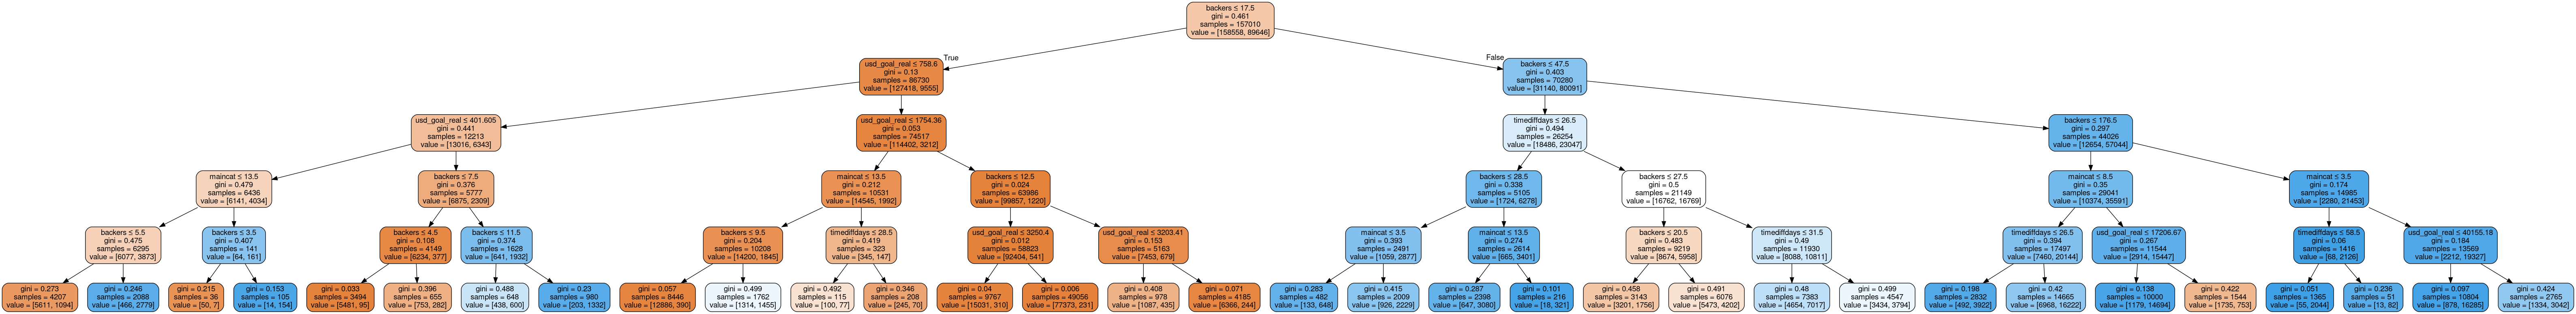

In [35]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz((model.best_estimator_.estimators_[0]) , out_file=dot_data,  
                filled=True, rounded=True,
                feature_names = feature_names_1, 
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [36]:
features_2 = features_1
labels_2 = df['usd_pledged_real']

x_train, x_test, y_train, y_test = train_test_split(features_2, labels_2, test_size=0.33, random_state=42)

In [ ]:
model = RandomForestRegressor(n_estimators=10)
scoring = 'r2'
# estimates accuracy
scores = cross_validate(model, x_train, y_train, scoring=[scoring] , cv=10)
best_score = np.max(scores['test_' + scoring])
print('Random Tree Best Regressor')
print('best {0} score : {1}'.format(scoring, best_score))
# create predictions 
y_pred = cross_val_predict(model, x_train, y_train, cv = 10)
#print('true', confusion_matrix(y_train, y_pred), '\n predicted')

# Number of trees in random forest
n_estimators  = np.arange(10,30, 10)
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [3,4,5]
# Minimum number of samples required to split a node
min_samples_split = np.arange(2, 6, 2)
# Minimum number of samples required at each leaf node
min_samples_leaf = np.arange(2, 6, 2)
# Method of selecting samples for training each tree
param_grid= {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(param_grid)

model = RandomForestRegressor(n_estimators=10)
model = GridSearchCV(model, param_grid = param_grid,cv = 5,scoring=scoring, n_jobs = -1,  refit=True)

model = model.fit(x_train, y_train)


Random Tree Best Regressor
best r2 score : 0.6068557609829679


In [48]:
df['predicted_price'] = model.predict(features_1)

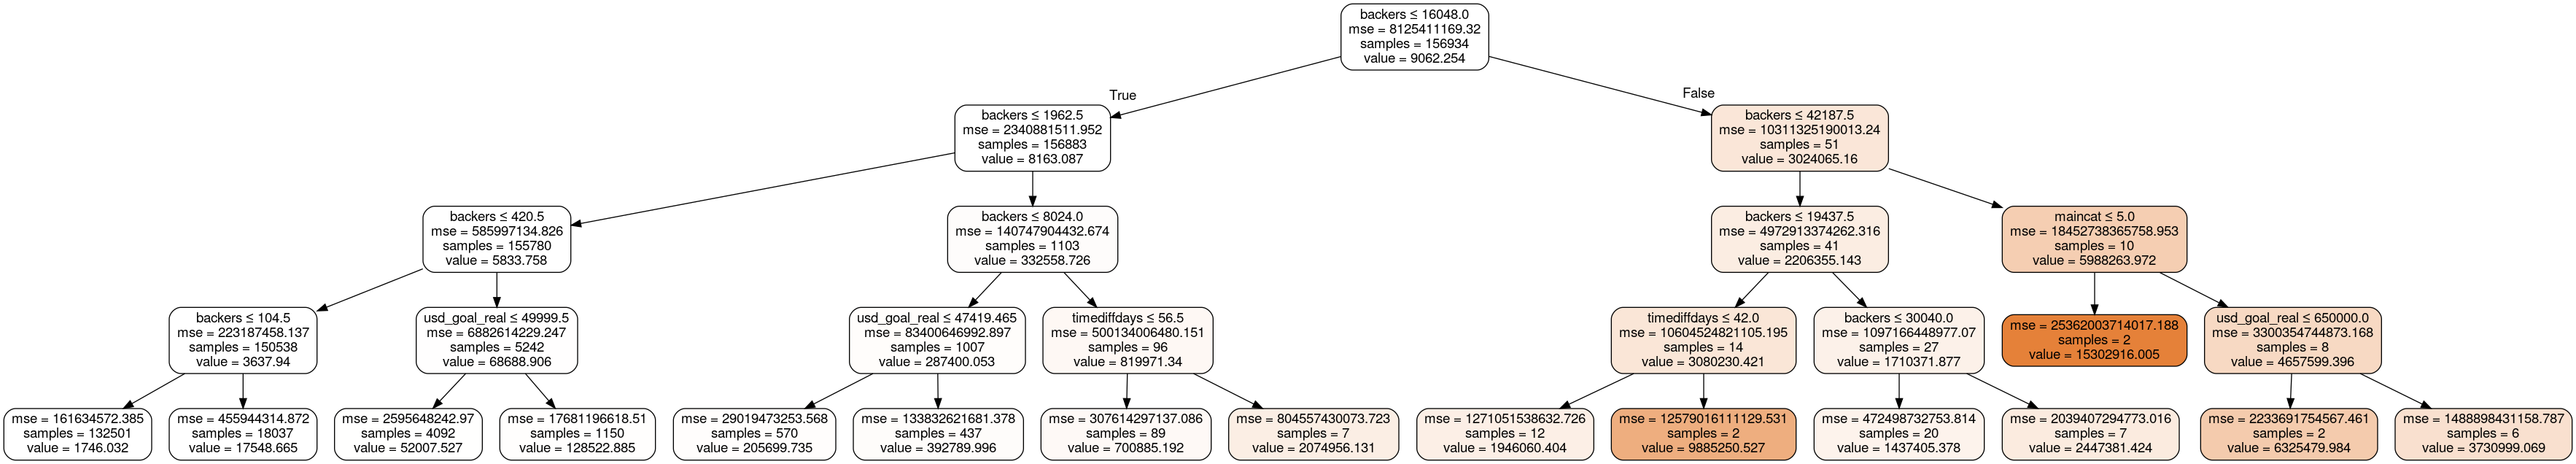

In [49]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz((model.best_estimator_.estimators_[0]) , out_file=dot_data,  
                filled=True, rounded=True,
                feature_names = feature_names_1, 
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [50]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,timediffdays,maincat,state_encoded,predicted_state,predicted_price
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,58,12,0,failed,2474.234862
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,59,6,0,failed,2474.234862
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,44,6,0,failed,2474.234862
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,29,10,0,failed,2474.234862
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,55,6,0,failed,2474.234862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,canceled,1,US,25.0,25.0,50000.00,29,6,0,failed,2474.234862
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,failed,5,US,155.0,155.0,1500.00,26,6,0,failed,2474.234862
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,failed,1,US,20.0,20.0,15000.00,45,6,0,failed,2474.234862
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,200.0,failed,6,US,200.0,200.0,15000.00,30,13,0,failed,2474.234862
